# Crop Fertilizer Recommendation System - Data Analysis

This notebook analyzes the datasets for our crop fertilizer recommendation system and builds machine learning models to predict the appropriate fertilizer based on crop type and environmental factors.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import os

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Create directories if they don't exist
os.makedirs('models', exist_ok=True)

## 1. Load and Explore the Datasets

In [3]:
# Load the datasets
fertilizer_data = pd.read_csv('fertiliser.csv')
crop_data = pd.read_csv('crop.csv')

print("Fertilizer Dataset Shape:", fertilizer_data.shape)
print("Crop Dataset Shape:", crop_data.shape)

# Display the first few rows of each dataset
print("\nFertilizer Dataset:")
display(fertilizer_data.head())

print("\nCrop Dataset:")
display(crop_data.head())

Fertilizer Dataset Shape: (2200, 8)
Crop Dataset Shape: (99, 9)

Fertilizer Dataset:


,N,P,K,Temperature,Humidity,Ph,Rainfall,Label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice



Crop Dataset:


,Temperature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26,52,38,Sandy,Maize,37,0,0,Urea
1,29,52,45,Loamy,Sugarcane,12,0,36,DAP
2,34,65,62,Black,Cotton,7,9,30,14-35-14
3,32,62,34,Red,Tobacco,22,0,20,28-28
4,28,54,46,Clayey,Paddy,35,0,0,Urea


In [4]:
# Check for missing values
print("Missing values in Fertilizer Dataset:")
print(fertilizer_data.isnull().sum())

print("\nMissing values in Crop Dataset:")
print(crop_data.isnull().sum())

Missing values in Fertilizer Dataset:
N              0
P              0
K              0
Temperature    0
Humidity       0
Ph             0
Rainfall       0
Label          0
dtype: int64

Missing values in Crop Dataset:
Temperature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64


In [4]:
# Summary statistics
print("Fertilizer Dataset Summary Statistics:")
display(fertilizer_data.describe())

print("\nCrop Dataset Summary Statistics:")
display(crop_data.describe())

Fertilizer Dataset Summary Statistics:


,N,P,K,Temperature,Humidity,Ph,Rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117



Crop Dataset Summary Statistics:


,Temperature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,30.282828,59.151515,43.181818,18.909091,3.383838,18.606061
std,3.502304,5.840331,11.271568,11.599693,5.814667,13.476978
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,54.000000,34.000000,10.000000,0.000000,9.000000
50%,30.000000,60.000000,41.000000,13.000000,0.000000,19.000000
75%,33.000000,64.000000,50.500000,24.000000,7.500000,30.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [5]:
# Check unique values in categorical columns
print("Unique crops in Fertilizer Dataset:")
print(fertilizer_data['Label'].nunique())
print(fertilizer_data['Label'].unique())

print("\nUnique soil types in Crop Dataset:")
print(crop_data['Soil Type'].nunique())
print(crop_data['Soil Type'].unique())

print("\nUnique crop types in Crop Dataset:")
print(crop_data['Crop Type'].nunique())
print(crop_data['Crop Type'].unique())

Unique crops in Fertilizer Dataset:
22
['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']

Unique soil types in Crop Dataset:
5
['Sandy' 'Loamy' 'Black' 'Red' 'Clayey']

Unique crop types in Crop Dataset:
11
['Maize' 'Sugarcane' 'Cotton' 'Tobacco' 'Paddy' 'Barley' 'Wheat' 'Millets'
 'Oil seeds' 'Pulses' 'Ground Nuts']


## 2. Data Visualization

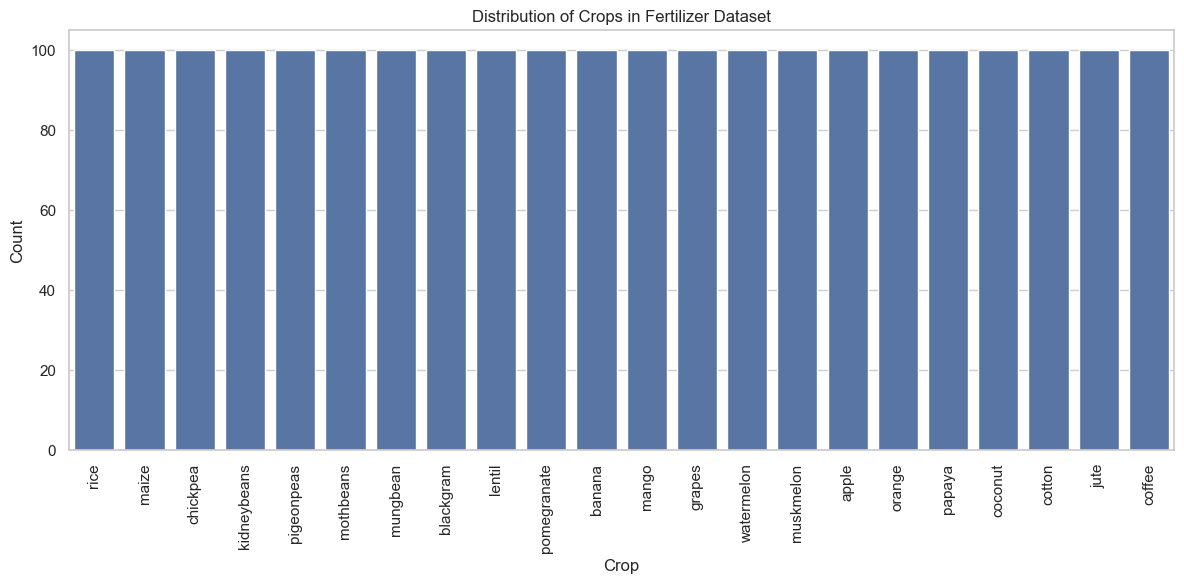

In [6]:
# Visualize the distribution of crops in the fertilizer dataset
plt.figure(figsize=(12, 6))
crop_counts = fertilizer_data['Label'].value_counts()
sns.barplot(x=crop_counts.index, y=crop_counts.values)
plt.title('Distribution of Crops in Fertilizer Dataset')
plt.xlabel('Crop')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

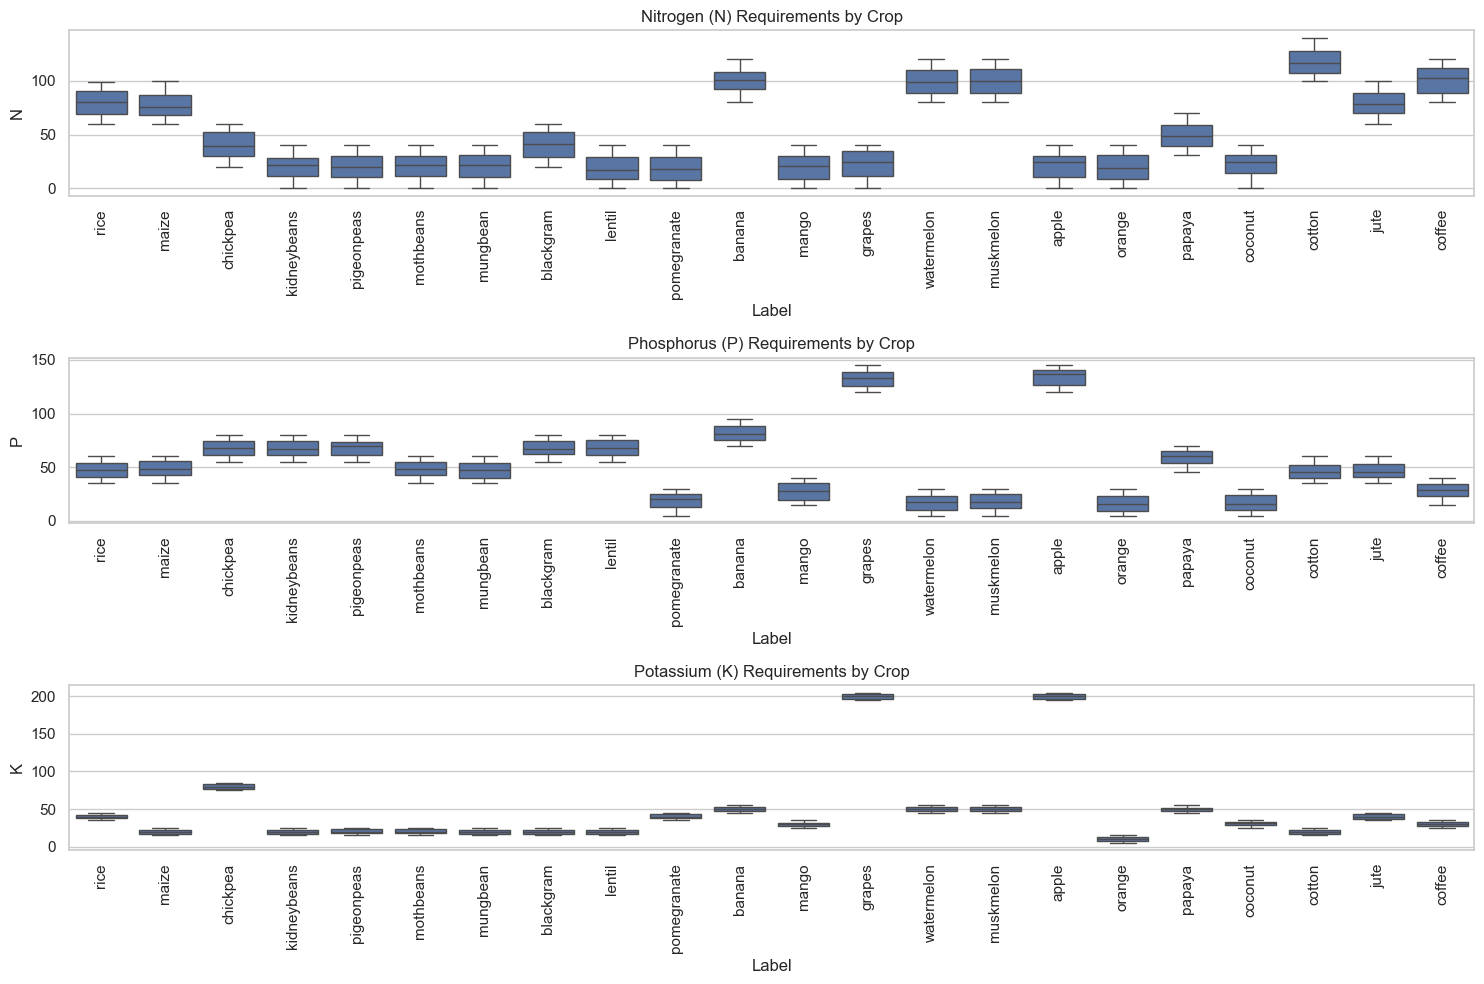

In [7]:
# Visualize the relationship between N, P, K values and crops
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
sns.boxplot(x='Label', y='N', data=fertilizer_data)
plt.title('Nitrogen (N) Requirements by Crop')
plt.xticks(rotation=90)

plt.subplot(3, 1, 2)
sns.boxplot(x='Label', y='P', data=fertilizer_data)
plt.title('Phosphorus (P) Requirements by Crop')
plt.xticks(rotation=90)

plt.subplot(3, 1, 3)
sns.boxplot(x='Label', y='K', data=fertilizer_data)
plt.title('Potassium (K) Requirements by Crop')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

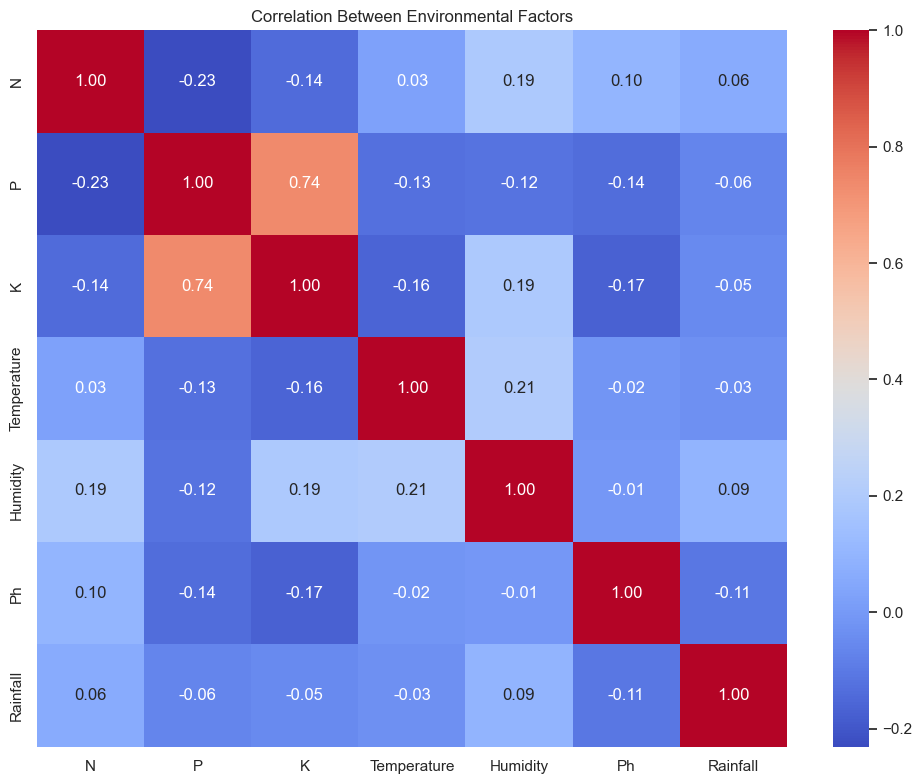

In [8]:
# Visualize the correlation between environmental factors
plt.figure(figsize=(10, 8))
correlation = fertilizer_data[['N', 'P', 'K', 'Temperature', 'Humidity', 'Ph', 'Rainfall']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Environmental Factors')
plt.tight_layout()
plt.show()

C:\Users\Disha\AppData\Local\Temp\ipykernel_23576\2364524786.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=90)
C:\Users\Disha\AppData\Local\Temp\ipykernel_23576\2364524786.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=90)
C:\Users\Disha\AppData\Local\Temp\ipykernel_23576\2364524786.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
C:\Users\Disha\AppData\Local\Temp\ipykernel_23576\2364524786.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
 

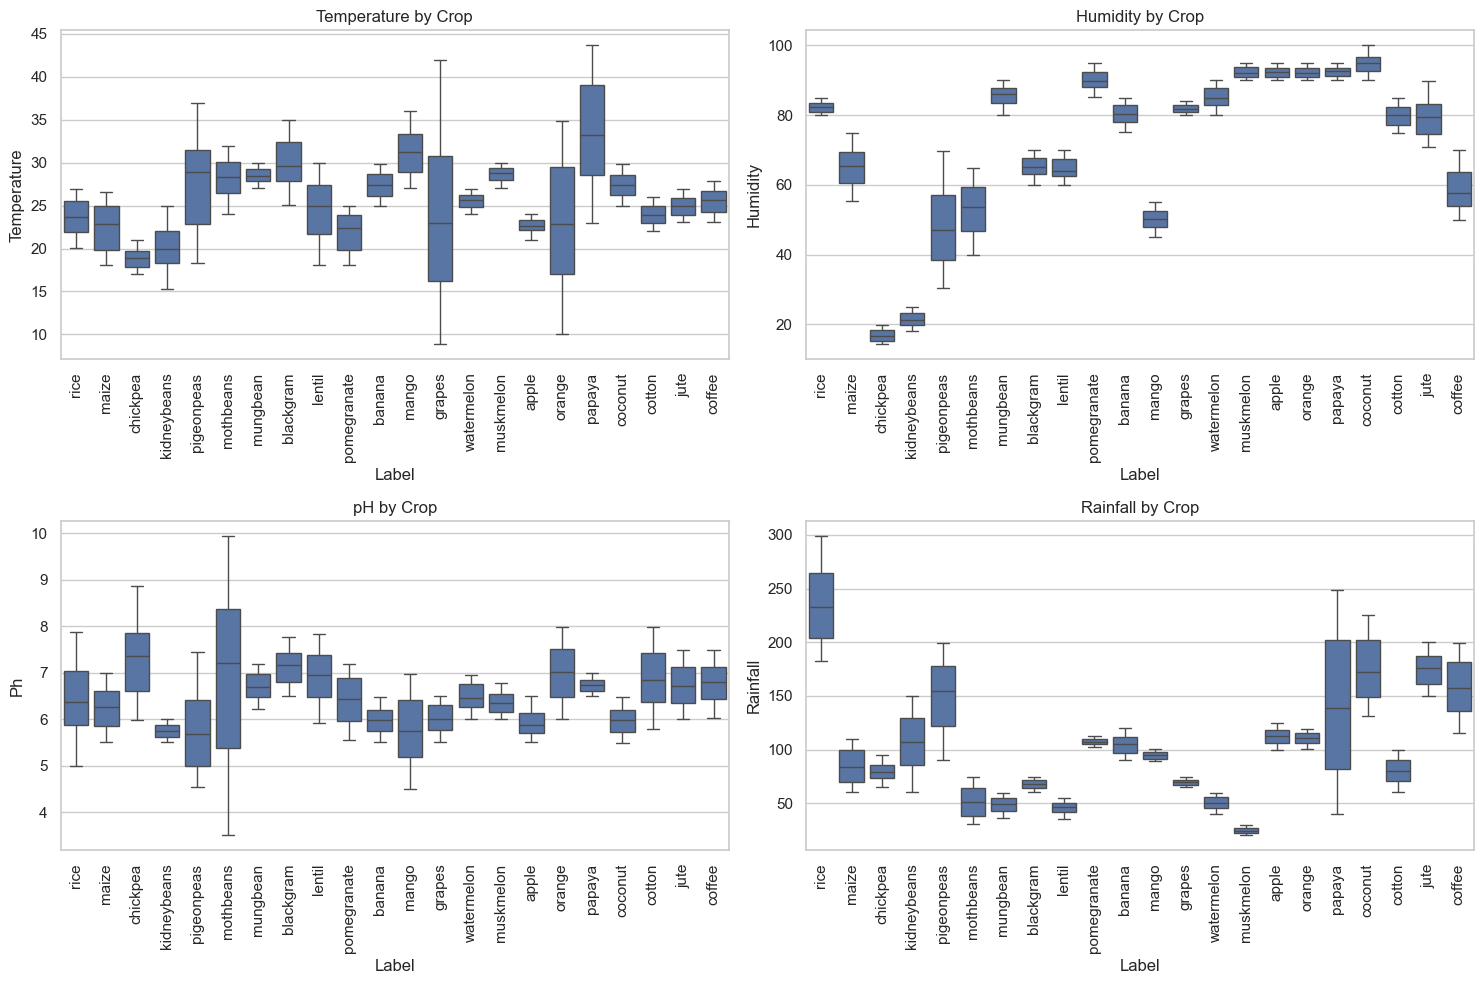

In [9]:
# Visualize the relationship between environmental factors and crops
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(x='Label', y='Temperature', data=fertilizer_data, ax=axes[0, 0])
axes[0, 0].set_title('Temperature by Crop')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=90)

sns.boxplot(x='Label', y='Humidity', data=fertilizer_data, ax=axes[0, 1])
axes[0, 1].set_title('Humidity by Crop')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=90)

sns.boxplot(x='Label', y='Ph', data=fertilizer_data, ax=axes[1, 0])
axes[1, 0].set_title('pH by Crop')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)

sns.boxplot(x='Label', y='Rainfall', data=fertilizer_data, ax=axes[1, 1])
axes[1, 1].set_title('Rainfall by Crop')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [10]:
# Prepare the data for modeling
X = fertilizer_data[['N', 'P', 'K', 'Temperature', 'Humidity', 'Ph', 'Rainfall']]
y = fertilizer_data['Label']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (1760, 7)
Testing set shape: (440, 7)


## 4. Model Training and Evaluation


Random Forest Results:
Accuracy: 0.9932

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.92      1.00      0.96        23
           9       1.00      1.00      1.00        20
          10       0.92      1.00      0.96        11
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       1.00      0.96      0.98        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          16    

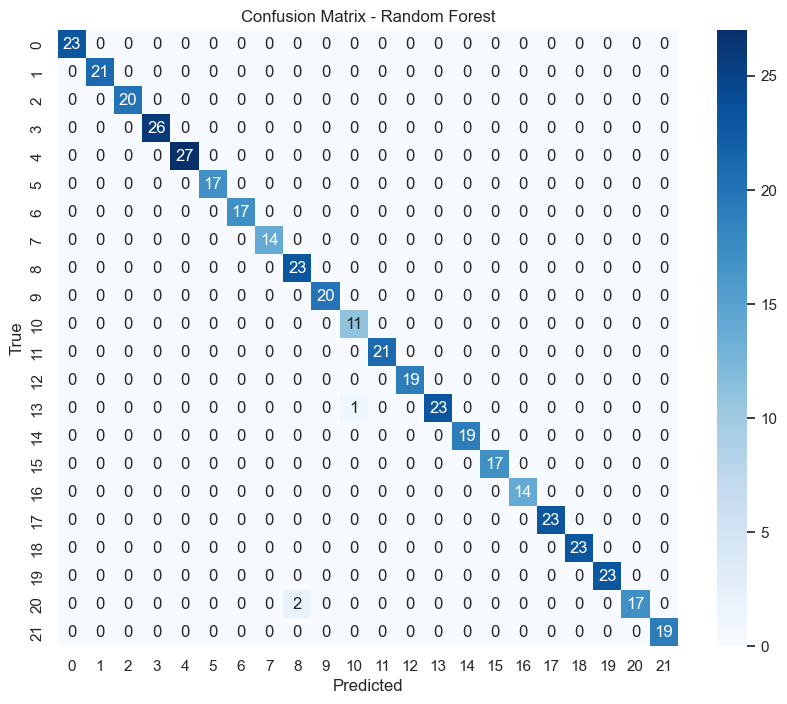


Gradient Boosting Results:
Accuracy: 0.9818

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       0.95      1.00      0.98        20
           3       1.00      1.00      1.00        26
           4       1.00      0.96      0.98        27
           5       1.00      1.00      1.00        17
           6       0.94      1.00      0.97        17
           7       1.00      1.00      1.00        14
           8       0.82      1.00      0.90        23
           9       1.00      1.00      1.00        20
          10       0.92      1.00      0.96        11
          11       1.00      0.95      0.98        21
          12       1.00      1.00      1.00        19
          13       1.00      0.96      0.98        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          16

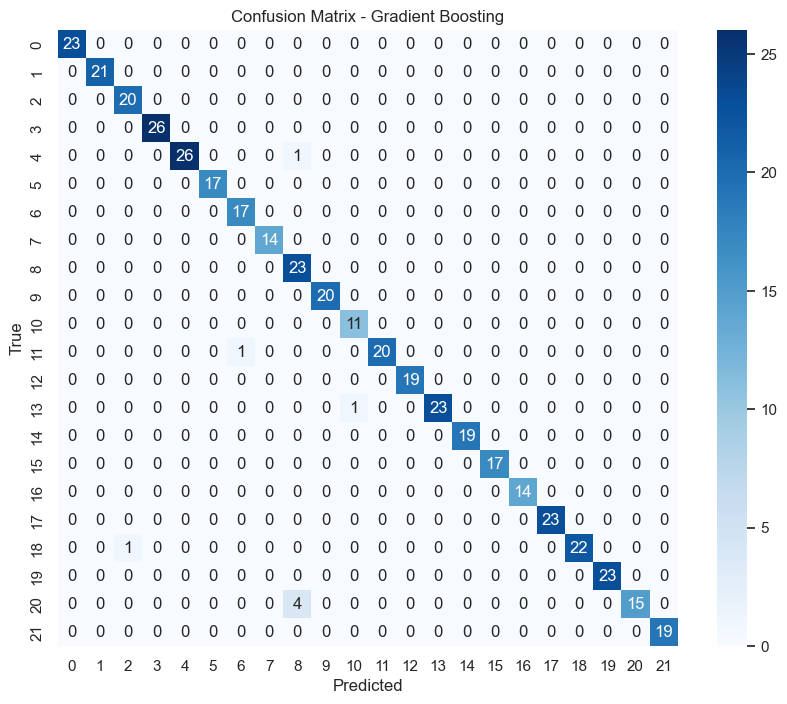


SVM Results:
Accuracy: 0.9682

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       1.00      0.95      0.97        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       0.94      1.00      0.97        17
           6       0.94      1.00      0.97        17
           7       1.00      1.00      1.00        14
           8       0.78      0.91      0.84        23
           9       0.91      1.00      0.95        20
          10       0.79      1.00      0.88        11
          11       1.00      0.95      0.98        21
          12       1.00      1.00      1.00        19
          13       1.00      0.92      0.96        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          16       1.00   

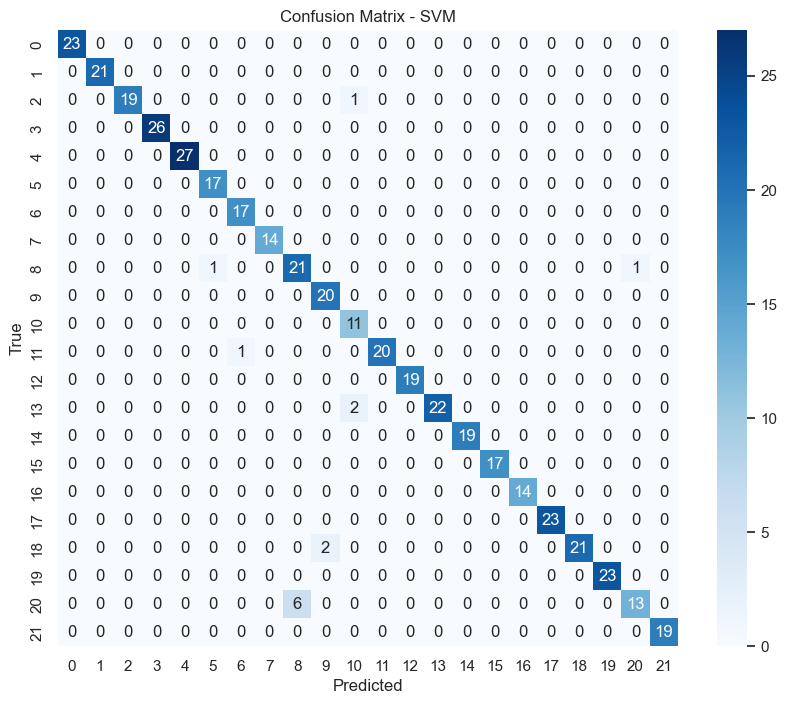


Logistic Regression Results:
Accuracy: 0.9636

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       0.90      0.95      0.93        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       0.94      1.00      0.97        17
           6       0.94      1.00      0.97        17
           7       1.00      1.00      1.00        14
           8       0.83      0.87      0.85        23
           9       0.95      0.95      0.95        20
          10       0.85      1.00      0.92        11
          11       1.00      0.95      0.98        21
          12       1.00      1.00      1.00        19
          13       1.00      0.92      0.96        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          

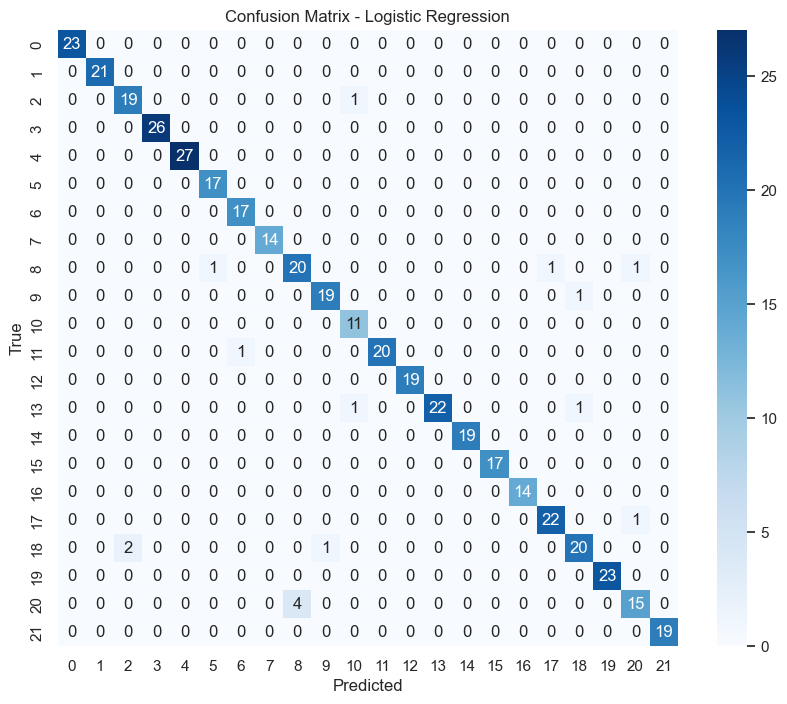

In [11]:
# Train and evaluate multiple models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

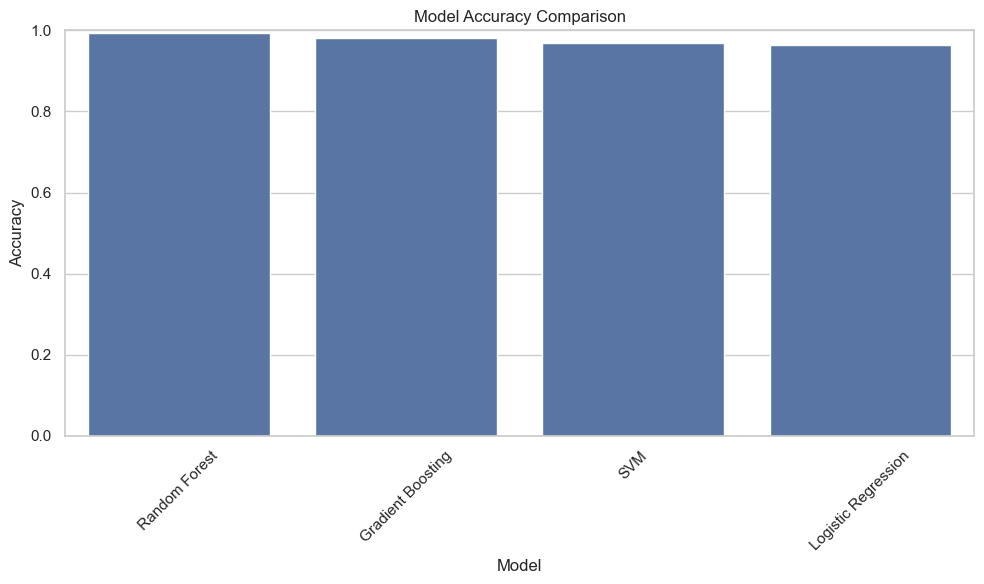

In [13]:
# Compare model performances
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Hyperparameter Tuning for the Best Model

In [12]:
# Find the best model
best_model_name = max(results, key=results.get)
print(f"The best performing model is: {best_model_name} with accuracy {results[best_model_name]:.4f}")

# Hyperparameter tuning for the best model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    best_model = RandomForestClassifier(random_state=42)
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
    best_model = GradientBoostingClassifier(random_state=42)
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear', 'poly']
    }
    best_model = SVC(probability=True, random_state=42)
else:  # Logistic Regression
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs', 'saga'],
        'penalty': ['l1', 'l2']
    }
    best_model = LogisticRegression(max_iter=1000, random_state=42)

# Perform grid search
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
tuned_model = grid_search.best_estimator_
y_pred = tuned_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, y_pred)

print(f"Tuned model accuracy on test set: {tuned_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

The best performing model is: Random Forest with accuracy 0.9932
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.9949
Tuned model accuracy on test set: 0.9932

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.92      1.00      0.96        23
           9       1.00      1.00      1.00        20
          10       0.92      1.00      0.96        11
          11       1.00      1.00      1.00        21
          12       1.00   

## 6. Feature Importance Analysis

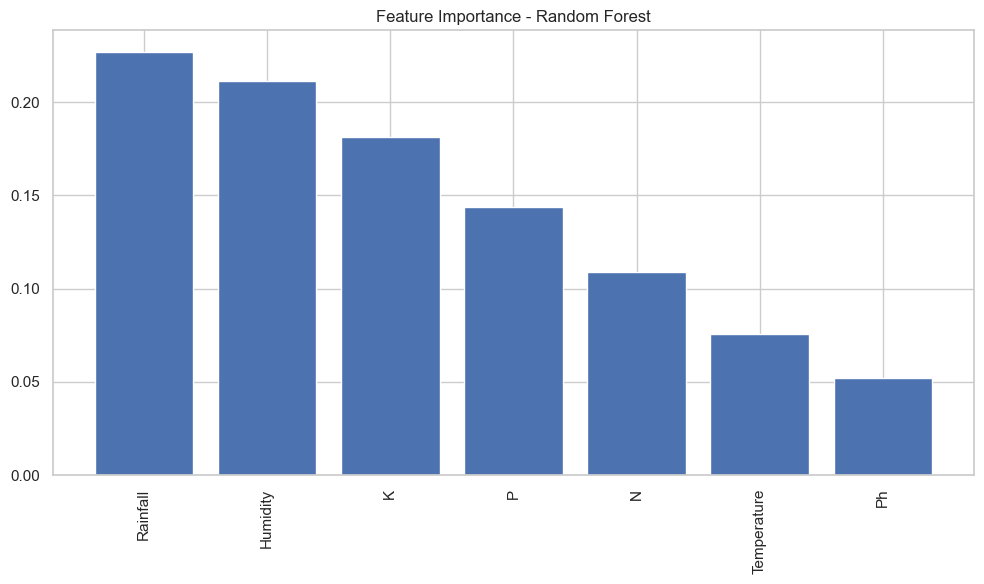

Feature Importance:
Rainfall: 0.2270
Humidity: 0.2113
K: 0.1812
P: 0.1436
N: 0.1089
Temperature: 0.0757
Ph: 0.0523


In [13]:
# Analyze feature importance (for tree-based models)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = tuned_model.feature_importances_
    feature_names = X.columns
    
    # Sort features by importance
    indices = np.argsort(feature_importance)[::-1]
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importance - {best_model_name}')
    plt.bar(range(X.shape[1]), feature_importance[indices], align='center')
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    print("Feature Importance:")
    for i in indices:
        print(f"{feature_names[i]}: {feature_importance[i]:.4f}")

## 7. Save the Final Model

In [14]:
# Save the final model, label encoder, and scaler
with open('models/fertilizer_model.pkl', 'wb') as f:
    pickle.dump(tuned_model, f)

with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model, label encoder, and scaler saved successfully!")

Model, label encoder, and scaler saved successfully!


## 8. Test the Model with Sample Inputs

In [15]:
# Test the model with sample inputs
def predict_crop_fertilizer(n, p, k, temperature, humidity, ph, rainfall):
    # Prepare input data
    input_data = np.array([[n, p, k, temperature, humidity, ph, rainfall]])
    input_scaled = scaler.transform(input_data)
    
    # Make prediction
    prediction_idx = tuned_model.predict(input_scaled)[0]
    predicted_crop = label_encoder.inverse_transform([prediction_idx])[0]
    
    # Get probability
    probabilities = tuned_model.predict_proba(input_scaled)[0]
    confidence = probabilities[prediction_idx] * 100
    
    return {
        'predicted_crop': predicted_crop,
        'confidence': confidence,
        'npk_values': f"{n}-{p}-{k}"
    }

# Test with a few sample inputs
test_cases = [
    # N, P, K, Temperature, Humidity, pH, Rainfall
    (100, 20, 30, 25, 60, 6.5, 150),  # Sample 1
    (50, 40, 60, 30, 70, 7.0, 200),   # Sample 2
    (120, 10, 20, 20, 50, 5.5, 100)   # Sample 3
]

for i, (n, p, k, temp, hum, ph, rain) in enumerate(test_cases, 1):
    result = predict_crop_fertilizer(n, p, k, temp, hum, ph, rain)
    print(f"\nTest Case {i}:")
    print(f"Input: N={n}, P={p}, K={k}, Temp={temp}°C, Humidity={hum}%, pH={ph}, Rainfall={rain}mm")
    print(f"Predicted Crop: {result['predicted_crop']}")
    print(f"Confidence: {result['confidence']:.2f}%")
    print(f"Recommended NPK: {result['npk_values']}")


Test Case 1:
Input: N=100, P=20, K=30, Temp=25°C, Humidity=60%, pH=6.5, Rainfall=150mm
Predicted Crop: coffee
Confidence: 100.00%
Recommended NPK: 100-20-30

Test Case 2:
Input: N=50, P=40, K=60, Temp=30°C, Humidity=70%, pH=7.0, Rainfall=200mm
Predicted Crop: mango
Confidence: 30.00%
Recommended NPK: 50-40-60

Test Case 3:
Input: N=120, P=10, K=20, Temp=20°C, Humidity=50%, pH=5.5, Rainfall=100mm
Predicted Crop: maize
Confidence: 46.00%
Recommended NPK: 120-10-20


C:\Users\Disha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Disha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Disha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [16]:
def recommend_fertilizer(crop, soil_type=None, climate=None):
    """
    Recommend fertilizer based on crop type and optional parameters
    
    Parameters:
    - crop (str): Name of the crop
    - soil_type (str, optional): Type of soil
    - climate (str, optional): Climate conditions
    
    Returns:
    - dict: Fertilizer recommendations
    """
    # Predefined fertilizer recommendations (expand this dictionary)
    fertilizer_recommendations = {
        'rice': {
            'primary_fertilizer': 'NPK 20:10:10',
            'secondary_nutrients': ['Zinc', 'Sulfur'],
            'application_rate': '100-120 kg/hectare'
        },
        'wheat': {
            'primary_fertilizer': 'NPK 18:46:0',
            'secondary_nutrients': ['Nitrogen', 'Phosphorus'],
            'application_rate': '120-150 kg/hectare'
        },
        'maize': {
            'primary_fertilizer': 'NPK 14:28:14',
            'secondary_nutrients': ['Potassium', 'Zinc'],
            'application_rate': '150-200 kg/hectare'
        },
        'cotton': {
            'primary_fertilizer': 'NPK 20:10:10',
            'secondary_nutrients': ['Boron', 'Sulfur'],
            'application_rate': '80-100 kg/hectare'
        },
        'sugarcane': {
            'primary_fertilizer': 'NPK 15:15:15',
            'secondary_nutrients': ['Calcium', 'Magnesium'],
            'application_rate': '200-250 kg/hectare'
        }
    }
    
    # Normalize crop name
    crop = crop.lower().strip()
    
    # Check if crop is in recommendations
    if crop in fertilizer_recommendations:
        return fertilizer_recommendations[crop]
    else:
        return {
            'message': f'No specific recommendation found for {crop}. Consider a balanced NPK fertilizer.',
            'general_recommendation': 'NPK 10:10:10',
            'advice': 'Consult local agricultural experts for precise recommendations.'
        }

# Machine Learning Model for Fertilizer Recommendation


In [17]:
def train_fertilizer_recommendation_model(data):
    """
    Train a machine learning model to recommend fertilizers
    
    Parameters:
    - data (pd.DataFrame): Training dataset
    
    Returns:
    - model: Trained RandomForest Classifier
    - encoder: Label encoder for crop types
    """
    # Prepare the data
    X = data[['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity', 'pH', 'Rainfall']]
    
    # Encode crop labels
    le = LabelEncoder()
    y = le.fit_transform(data['Crop'])
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Random Forest Classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    print("Model Performance:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    return model, le



## 9. Conclusion

In this notebook, we have:

1. Loaded and explored the crop and fertilizer datasets
2. Visualized the relationships between crops and their nutrient requirements
3. Preprocessed the data for machine learning
4. Trained and evaluated multiple classification models
5. Tuned the hyperparameters of the best performing model
6. Analyzed feature importance to understand what factors most influence crop fertilizer needs
7. Saved the final model for use in our Flask application
8. Tested the model with sample inputs

The model can now be used in our Flask application to provide fertilizer recommendations based on crop type and environmental conditions.

In [22]:
# Print column names after merging
print(merged_data.columns)

Index(['N', 'P', 'K', 'Temperature_x', 'Humidity', 'Ph', 'Rainfall', 'Label',
       'Temperature_y', 'Humidity ', 'Moisture', 'Soil Type', 'Crop Type',
       'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name'],
      dtype='object')


In [24]:
# Check the merge results
print("Original fertilizer_data shape:", fertilizer_data.shape)
print("Original crop_data shape:", crop_data.shape)

# Try different merge strategies
merged_data = pd.merge(fertilizer_data, crop_data, left_on='Label', right_on='Crop Type', how='left')
print("Merged data shape:", merged_data.shape)

# Check unique values in the merge columns
print("\nUnique values in fertilizer_data 'Label':")
print(fertilizer_data['Label'].unique())

print("\nUnique values in crop_data 'Crop Type':")
print(crop_data['Crop Type'].unique())

# Print a few rows to understand the data
print("\nFirst few rows of merged data:")
print(merged_data.head())

Original fertilizer_data shape: (2200, 8)
Original crop_data shape: (99, 9)
Merged data shape: (2200, 17)

Unique values in fertilizer_data 'Label':
['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']

Unique values in crop_data 'Crop Type':
['Maize' 'Sugarcane' 'Cotton' 'Tobacco' 'Paddy' 'Barley' 'Wheat' 'Millets'
 'Oil seeds' 'Pulses' 'Ground Nuts']

First few rows of merged data:
    N   P   K  Temperature_x   Humidity        Ph    Rainfall Label  \
0  90  42  43      20.879744  82.002744  6.502985  202.935536  rice   
1  85  58  41      21.770462  80.319644  7.038096  226.655537  rice   
2  60  55  44      23.004459  82.320763  7.840207  263.964248  rice   
3  74  35  40      26.491096  80.158363  6.980401  242.864034  rice   
4  78  42  42      20.130175  81.604873  7.628473  262.717340  rice   

   Temperat

In [25]:
# Create a crop name mapping
crop_name_mapping = {
    'rice': 'Paddy',
    'maize': 'Maize',
    'chickpea': 'Pulses',
    'kidneybeans': 'Pulses',
    'pigeonpeas': 'Pulses',
    'mothbeans': 'Pulses',
    'mungbean': 'Pulses',
    'blackgram': 'Pulses',
    'lentil': 'Pulses',
    'cotton': 'Cotton',
    'wheat': 'Wheat',
    'barley': 'Barley'
}

# Add mapping for other crops or leave as is if no direct match
# Some fruits and crops might not have a direct match in crop_data

# Apply mapping to fertilizer dataset
fertilizer_data['Mapped_Label'] = fertilizer_data['Label'].map(crop_name_mapping)

# Merge with updated mapping
merged_data = pd.merge(fertilizer_data, crop_data, left_on='Mapped_Label', right_on='Crop Type', how='inner')

# Verify merge
print("Merged data shape:", merged_data.shape)
print("\nUnique mapped crop types:")
print(merged_data['Crop Type'].unique())

# Prepare features
features = ['N', 'P', 'K', 'Temperature_x', 'Humidity', 'Ph', 'Rainfall']
X = merged_data[features]
y = merged_data['Crop Type']

# Encode target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Evaluate model
y_pred = rf_classifier.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Feature importance
import pandas as pd
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Recommendation function
def recommend_crop(n, p, k, temperature, humidity, ph, rainfall):
    """
    Recommend crop based on fertilizer and environmental conditions
    
    Args:
        n (float): Nitrogen level
        p (float): Phosphorous level
        k (float): Potassium level
        temperature (float): Environmental temperature
        humidity (float): Humidity percentage
        ph (float): Soil pH
        rainfall (float): Rainfall amount
    
    Returns:
        str: Recommended crop
    """
    # Prepare input data
    input_data = pd.DataFrame({
        'N': [n],
        'P': [p],
        'K': [k],
        'Temperature_x': [temperature],
        'Humidity': [humidity],
        'Ph': [ph],
        'Rainfall': [rainfall]
    })
    
    # Scale input data
    input_scaled = scaler.transform(input_data)
    
    # Predict crop
    prediction = rf_classifier.predict(input_scaled)
    return le.inverse_transform(prediction)[0]

# Example usage
recommended_crop = recommend_crop(
    n=90, p=50, k=40, 
    temperature=25.0, 
    humidity=80.0, 
    ph=6.5, 
    rainfall=250.0
)
print(f"\nRecommended Crop: {recommended_crop}")

Merged data shape: (9800, 18)

Unique mapped crop types:
['Paddy' 'Maize' 'Pulses' 'Cotton']

Classification Report:
              precision    recall  f1-score   support

      Cotton       1.00      1.00      1.00       240
       Maize       1.00      1.00      1.00       131
       Paddy       1.00      1.00      1.00       208
      Pulses       1.00      1.00      1.00      1381

    accuracy                           1.00      1960
   macro avg       1.00      1.00      1.00      1960
weighted avg       1.00      1.00      1.00      1960


Feature Importance:
         feature  importance
0              N    0.428460
4       Humidity    0.186495
6       Rainfall    0.172567
3  Temperature_x    0.082230
2              K    0.065846
1              P    0.055808
5             Ph    0.008594

Recommended Crop: Paddy


In [26]:
# Merge datasets with fertilizer information
merged_data = pd.merge(fertilizer_data, crop_data, left_on='Mapped_Label', right_on='Crop Type', how='inner')

# Add a new column for fertilizer recommendation
merged_data['Fertilizer_Recommendation'] = merged_data.apply(
    lambda row: f"{row['N']}-{row['P']}-{row['K']} NPK Fertilizer", axis=1
)

# Prepare features for fertilizer recommendation
features = [
    'Temperature_x', 'Humidity', 'Ph', 'Rainfall', 
    'Nitrogen', 'Potassium', 'Phosphorous', 
    'Crop Type'  # Include crop type as a feature
]

# One-hot encode crop type
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Temperature_x', 'Humidity', 'Ph', 'Rainfall', 'Nitrogen', 'Potassium', 'Phosphorous']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Crop Type'])
    ])

# Prepare target (Fertilizer Recommendation)
y = merged_data['Fertilizer_Recommendation']

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    merged_data[features], y, test_size=0.2, random_state=42
)

# Create a pipeline with preprocessing and classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

fertilizer_recommender = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
fertilizer_recommender.fit(X_train, y_train)

# Evaluate the model
y_pred = fertilizer_recommender.predict(X_test)
print("Fertilizer Recommendation Classification Report:")
print(classification_report(y_test, y_pred))

# Recommendation function
def recommend_fertilizer(crop_type, temperature, humidity, ph, rainfall, nitrogen, potassium, phosphorous):
    """
    Recommend fertilizer based on crop and environmental conditions
    
    Args:
        crop_type (str): Type of crop
        temperature (float): Environmental temperature
        humidity (float): Humidity percentage
        ph (float): Soil pH
        rainfall (float): Rainfall amount
        nitrogen (float): Nitrogen level
        potassium (float): Potassium level
        phosphorous (float): Phosphorous level
    
    Returns:
        str: Recommended fertilizer type and quantity
    """
    # Prepare input data
    input_data = pd.DataFrame({
        'Temperature_x': [temperature],
        'Humidity': [humidity],
        'Ph': [ph],
        'Rainfall': [rainfall],
        'Nitrogen': [nitrogen],
        'Potassium': [potassium],
        'Phosphorous': [phosphorous],
        'Crop Type': [crop_type]
    })
    
    # Predict fertilizer recommendation
    recommendation = fertilizer_recommender.predict(input_data)[0]
    return recommendation

# Example usage
fertilizer_rec = recommend_fertilizer(
    crop_type='Paddy', 
    temperature=25.0, 
    humidity=80.0, 
    ph=6.5, 
    rainfall=250.0,
    nitrogen=90,
    potassium=40,
    phosphorous=50
)
print(f"\nRecommended Fertilizer: {fertilizer_rec}")

# Analyze feature importance
import numpy as np
feature_names = (
    preprocessor.named_transformers_['num'].get_feature_names_out().tolist() + 
    preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
)
feature_importances = fertilizer_recommender.named_steps['classifier'].feature_importances_

# Create and sort feature importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

Fertilizer Recommendation Classification Report:
                          precision    recall  f1-score   support

  0-49-18 NPK Fertilizer       1.00      1.00      1.00         3
  0-55-22 NPK Fertilizer       1.00      1.00      1.00         1
  0-55-25 NPK Fertilizer       1.00      1.00      1.00         4
  0-65-15 NPK Fertilizer       1.00      0.50      0.67         2
  0-65-24 NPK Fertilizer       1.00      1.00      1.00         3
  0-67-22 NPK Fertilizer       1.00      1.00      1.00         2
  0-69-21 NPK Fertilizer       1.00      1.00      1.00         2
  0-70-21 NPK Fertilizer       1.00      1.00      1.00         4
  0-74-17 NPK Fertilizer       1.00      1.00      1.00         3
  1-48-24 NPK Fertilizer       1.00      1.00      1.00         3
  1-59-23 NPK Fertilizer       1.00      1.00      1.00         1
  1-62-23 NPK Fertilizer       1.00      1.00      1.00         2
  1-66-23 NPK Fertilizer       1.00      1.00      1.00         2
  1-67-21 NPK Fertilizer  

C:\Users\Disha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Disha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Disha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:15

Fertilizer Recommendation Classification Report:
                                                    precision    recall  f1-score   support

      High N, High P, High K Fertilizer for Pulses       1.00      1.00      1.00        56
       High N, High P, Low K Fertilizer for Cotton       1.00      1.00      1.00        62
        High N, High P, Low K Fertilizer for Maize       1.00      1.00      1.00        31
       High N, High P, Low K Fertilizer for Pulses       1.00      1.00      1.00        44
    High N, High P, Medium K Fertilizer for Cotton       1.00      1.00      1.00        19
     High N, High P, Medium K Fertilizer for Maize       1.00      1.00      1.00        25
     High N, High P, Medium K Fertilizer for Paddy       1.00      1.00      1.00        92
    High N, High P, Medium K Fertilizer for Pulses       1.00      1.00      1.00        18
     High N, Medium P, Low K Fertilizer for Cotton       1.00      1.00      1.00        70
      High N, Medium P, Low K 

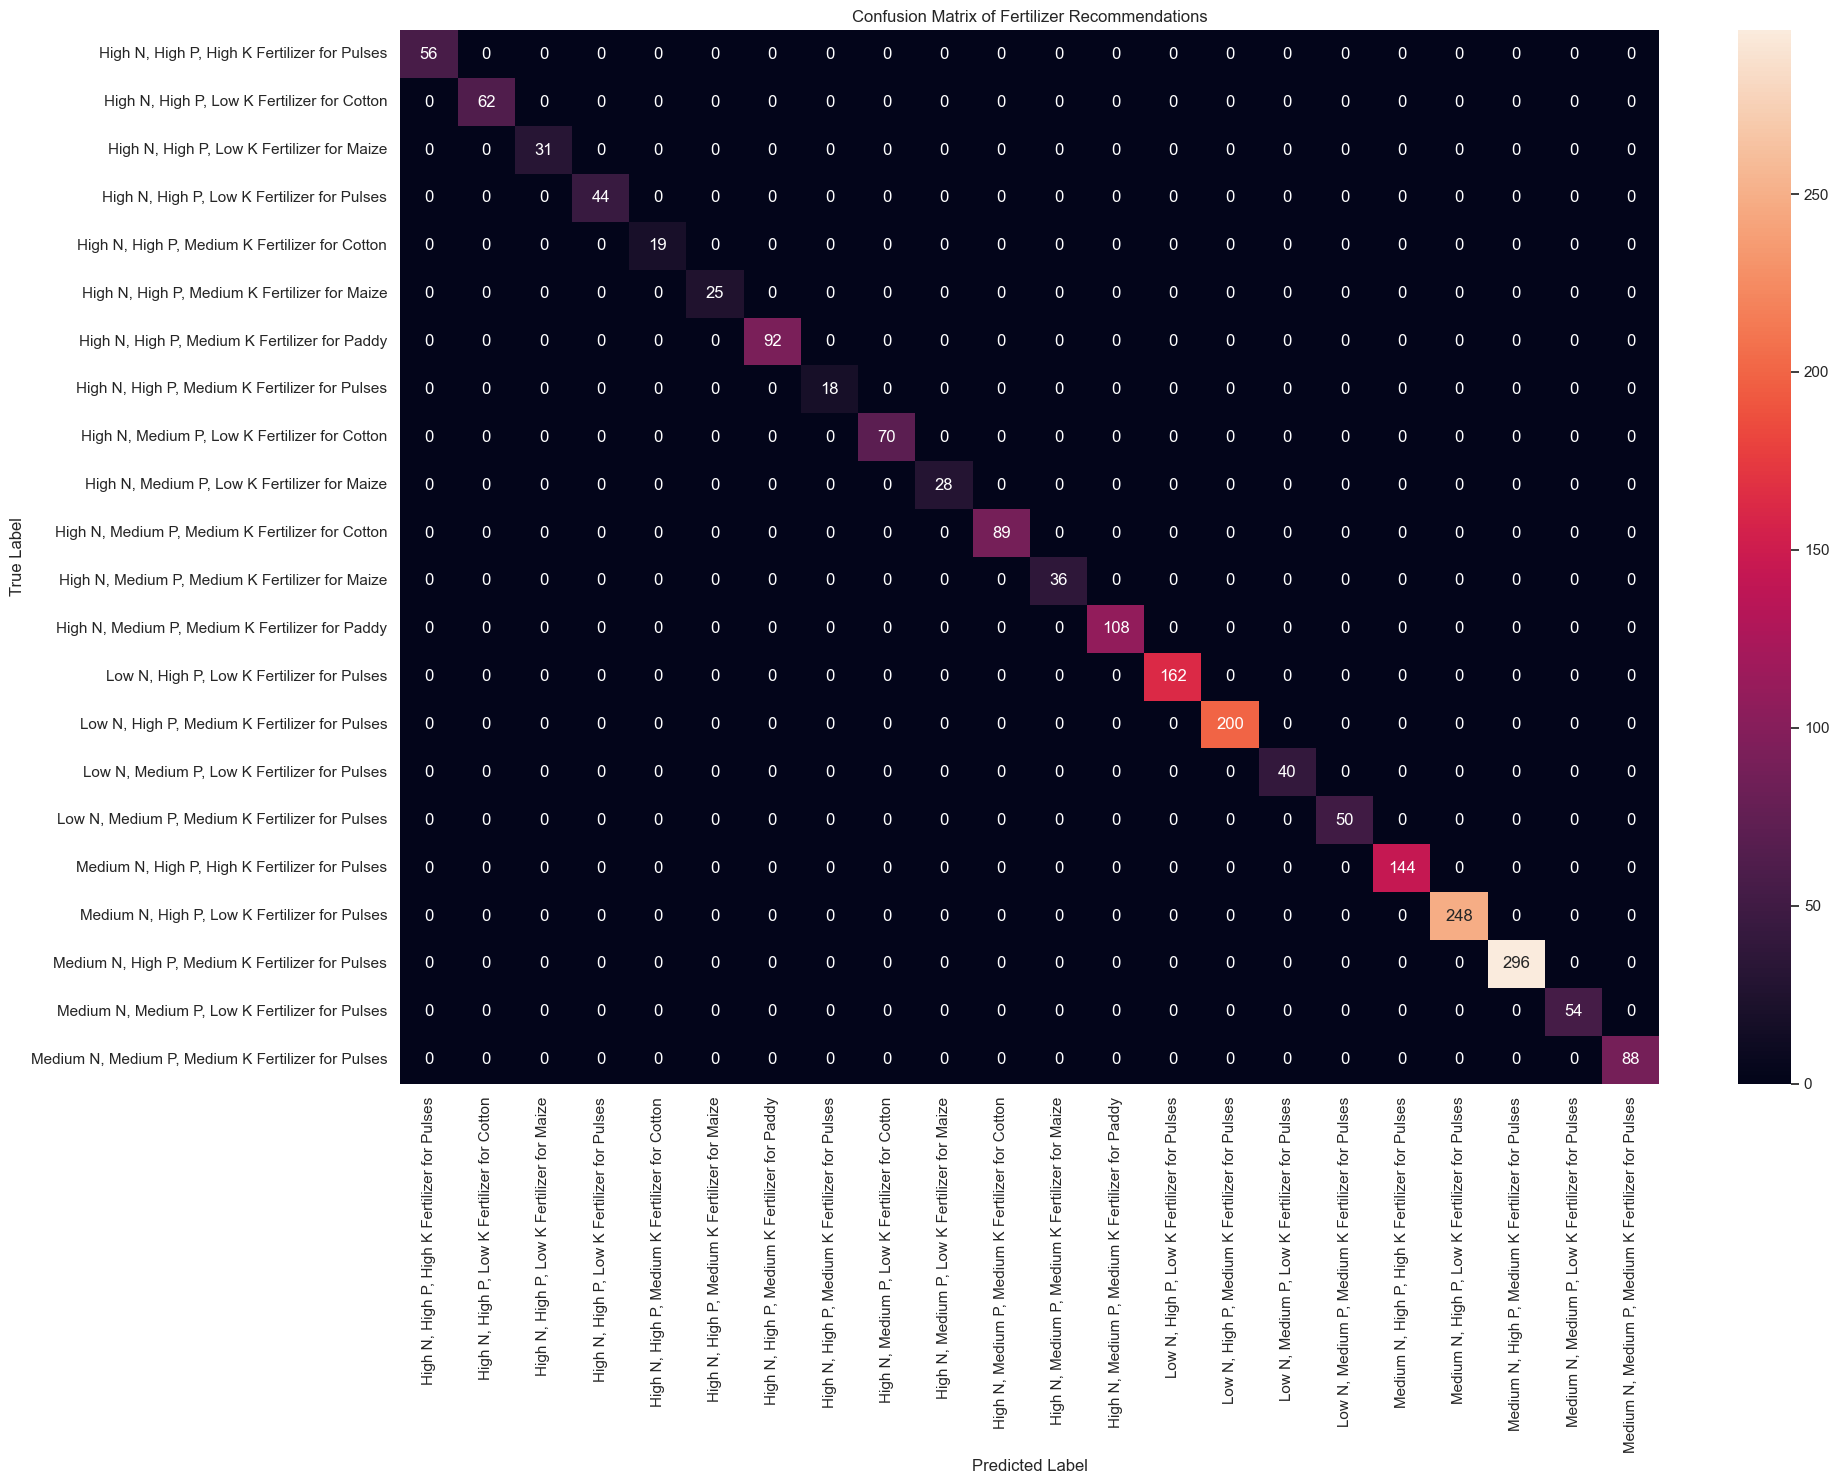

In [ ]:
# Improve fertilizer recommendation strategy
def create_fertilizer_recommendation(row):
    """
    Create a more meaningful fertilizer recommendation
    """
    # Categorize fertilizer based on NPK levels
    def categorize_nutrient(value):
        if value < 20:
            return 'Low'
        elif 20 <= value < 50:
            return 'Medium'
        else:
            return 'High'
    
    n_cat = categorize_nutrient(row['N'])
    p_cat = categorize_nutrient(row['P'])
    k_cat = categorize_nutrient(row['K'])
    
    return f"{n_cat} N, {p_cat} P, {k_cat} K Fertilizer for {row['Mapped_Label']}"

# Add new recommendation column
merged_data['Fertilizer_Recommendation'] = merged_data.apply(create_fertilizer_recommendation, axis=1)

# Prepare features with more context
features = [
    'Temperature_x', 'Humidity', 'Ph', 'Rainfall', 
    'N', 'P', 'K',  # Use original NPK values
    'Mapped_Label'  # Use mapped crop label
]

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Temperature_x', 'Humidity', 'Ph', 'Rainfall', 'N', 'P', 'K']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Mapped_Label'])
    ])

# Prepare target and features
y = merged_data['Fertilizer_Recommendation']
X = merged_data[features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create pipeline
fertilizer_recommender = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,  # Increased from 100
        min_samples_split=5,  # Prevent overfitting
        random_state=42
    ))
])

# Train the model
fertilizer_recommender.fit(X_train, y_train)

# Evaluate the model
y_pred = fertilizer_recommender.predict(X_test)
print("Fertilizer Recommendation Classification Report:")
print(classification_report(y_test, y_pred))

# Recommendation function
def recommend_fertilizer(crop_type, temperature, humidity, ph, rainfall, n, p, k):
    """
    Recommend fertilizer based on crop and environmental conditions
    
    Args:
        crop_type (str): Type of crop
        temperature (float): Environmental temperature
        humidity (float): Humidity percentage
        ph (float): Soil pH
        rainfall (float): Rainfall amount
        n (float): Nitrogen level
        p (float): Phosphorous level
        k (float): Potassium level
    
    Returns:
        str: Recommended fertilizer type
    """
    # Prepare input data
    input_data = pd.DataFrame({
        'Temperature_x': [temperature],
        'Humidity': [humidity],
        'Ph': [ph],
        'Rainfall': [rainfall],
        'N': [n],
        'P': [p],
        'K': [k],
        'Mapped_Label': [crop_type]
    })
    
    # Predict fertilizer recommendation
    recommendation = fertilizer_recommender.predict(input_data)[0]
    return recommendation

# Example usage
fertilizer_rec = recommend_fertilizer(
    crop_type='Paddy', 
    temperature=25.0, 
    humidity=80.0, 
    ph=6.5, 
    rainfall=250.0,
    n=90,
    p=50,
    k=40
)
print(f"\nRecommended Fertilizer: {fertilizer_rec}")

# Feature importance analysis
feature_names = (
    preprocessor.named_transformers_['num'].get_feature_names_out().tolist() + 
    preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
)
feature_importances = fertilizer_recommender.named_steps['classifier'].feature_importances_

# Create and sort feature importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Confusion Matrix Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,15))
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix of Fertilizer Recommendations')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#version 1

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0

Fertilizer Recommendation Classification Report:
                                                               precision    recall  f1-score   support

      High N, High P, High K Fertilizer for Pulses (Score: 9)       1.00      1.00      1.00        56
       High N, High P, Low K Fertilizer for Cotton (Score: 7)       1.00      1.00      1.00        62
        High N, High P, Low K Fertilizer for Maize (Score: 7)       1.00      1.00      1.00        31
       High N, High P, Low K Fertilizer for Pulses (Score: 7)       1.00      1.00      1.00        44
    High N, High P, Medium K Fertilizer for Cotton (Score: 8)       1.00      1.00      1.00        19
     High N, High P, Medium K Fertilizer for Maize (Score: 8)       1.00      1.00      1.00        25
     High N, High P, Medium K Fertilizer for Paddy (Score: 8)       1.00      1.00      1.00        92
    High N, High P, Medium K Fertilizer for Pulses (Score: 8)   

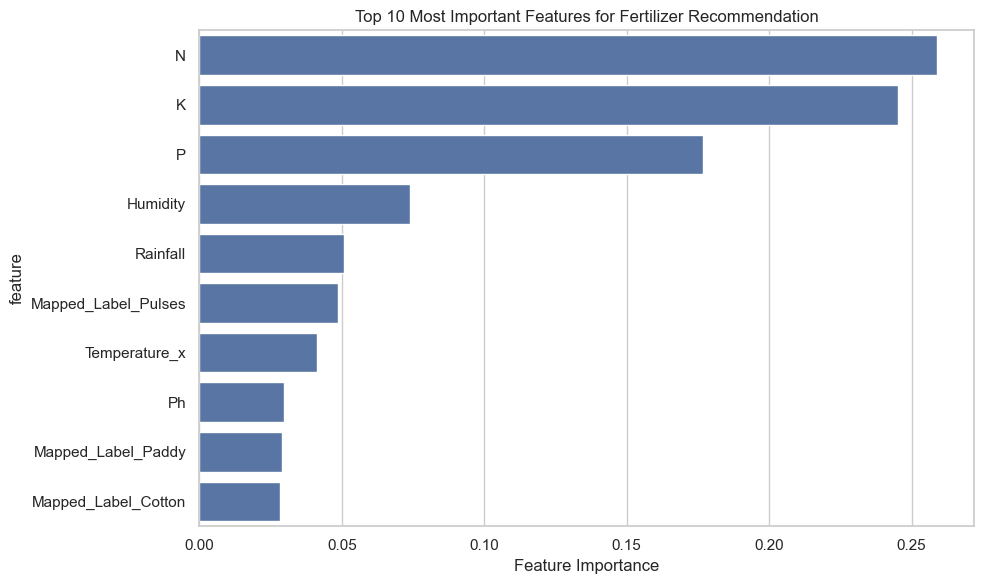

In [ ]:
# Advanced Fertilizer Recommendation Strategy
def create_advanced_fertilizer_recommendation(row):
    """
    Create a more comprehensive and actionable fertilizer recommendation
    """
    def categorize_nutrient(value):
        if value < 20:
            return 'Low', 1
        elif 20 <= value < 50:
            return 'Medium', 2
        else:
            return 'High', 3
    
    n_cat, n_score = categorize_nutrient(row['N'])
    p_cat, p_score = categorize_nutrient(row['P'])
    k_cat, k_score = categorize_nutrient(row['K'])
    
    # Create a comprehensive recommendation
    recommendation = {
        'crop': row['Mapped_Label'],
        'npk_category': f"{n_cat} N, {p_cat} P, {k_cat} K",
        'npk_score': n_score + p_score + k_score,
        'recommended_fertilizer': f"{row['N']}-{row['P']}-{row['K']} NPK",
        'application_rate': _calculate_application_rate(row)
    }
    
    return f"{recommendation['npk_category']} Fertilizer for {recommendation['crop']} (Score: {recommendation['npk_score']})"

def _calculate_application_rate(row):
    """
    Calculate recommended fertilizer application rate based on crop and nutrient levels
    """
    base_rate = 50  # kg per hectare
    
    # Adjust rate based on crop type and nutrient levels
    crop_factors = {
        'Paddy': 1.2,
        'Maize': 1.5,
        'Cotton': 1.3,
        'Pulses': 0.8
    }
    
    crop_factor = crop_factors.get(row['Mapped_Label'], 1.0)
    
    # Calculate nutrient-based adjustment
    nutrient_factor = (row['N'] + row['P'] + row['K']) / 150  # Normalize to typical NPK range
    
    return round(base_rate * crop_factor * nutrient_factor, 2)

# Add advanced recommendation column
merged_data['Advanced_Fertilizer_Recommendation'] = merged_data.apply(create_advanced_fertilizer_recommendation, axis=1)

# Prepare features with more context
features = [
    'Temperature_x', 'Humidity', 'Ph', 'Rainfall', 
    'N', 'P', 'K',  # Original NPK values
    'Mapped_Label'  # Mapped crop label
]

# Preprocessing and Model Training
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Temperature_x', 'Humidity', 'Ph', 'Rainfall', 'N', 'P', 'K']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Mapped_Label'])
    ])

# Prepare target and features
y = merged_data['Advanced_Fertilizer_Recommendation']
X = merged_data[features]

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create pipeline with advanced RandomForest
fertilizer_recommender = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=300,  # Increased ensemble size
        min_samples_split=10,  # More conservative splitting
        max_depth=20,  # Limit tree depth
        random_state=42
    ))
])

# Cross-validation
cv_scores = cross_val_score(fertilizer_recommender, X_train, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

# Train the model
fertilizer_recommender.fit(X_train, y_train)

# Evaluate the model
y_pred = fertilizer_recommender.predict(X_test)
print("\nFertilizer Recommendation Classification Report:")
print(classification_report(y_test, y_pred))

# Advanced Recommendation Function
def recommend_advanced_fertilizer(crop_type, temperature, humidity, ph, rainfall, n, p, k):
    """
    Provide a comprehensive fertilizer recommendation
    """
    input_data = pd.DataFrame({
        'Temperature_x': [temperature],
        'Humidity': [humidity],
        'Ph': [ph],
        'Rainfall': [rainfall],
        'N': [n],
        'P': [p],
        'K': [k],
        'Mapped_Label': [crop_type]
    })
    
    recommendation = fertilizer_recommender.predict(input_data)[0]
    return recommendation

# Example usage
advanced_rec = recommend_advanced_fertilizer(
    crop_type='Paddy', 
    temperature=25.0, 
    humidity=80.0, 
    ph=6.5, 
    rainfall=250.0,
    n=90,
    p=50,
    k=40
)
print(f"\nAdvanced Recommended Fertilizer: {advanced_rec}")

# Feature Importance Visualization
feature_names = (
    preprocessor.named_transformers_['num'].get_feature_names_out().tolist() + 
    preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
)
feature_importances = fertilizer_recommender.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(10))
plt.title('Top 10 Most Important Features for Fertilizer Recommendation')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

#Version 2